# Python script for STXSM stacks

The scope of this script is to analyse STXSM stacks.

A STXSM (Scanning Transmission X-ray Scattering Microscopy) image stack is a collection of two-dimensional images acquired using the STXSM technique. STXSM is an imaging method that combines scanning transmission X-ray microscopy (STXM) with X-ray scattering measurements. In a STXSM image stack, a sample is placed under an intense beam of X-rays, and a detector captures the transmitted X-rays as they interact with the sample. By scanning the sample and collecting a series of images at different positions, a stack of two-dimensional images is obtained. Each image in the stack provides information about the sample's local structure and composition. The X-ray scattering patterns recorded in the images contain valuable insights into the sample's nanoscale properties, such as its atomic arrangement, molecular orientation, and spatial distribution of different materials. The STXSM image stack can be analyzed and processed using various techniques, such as data reconstruction algorithms and image analysis methods, to extract quantitative information and reveal the underlying structural and chemical properties of the sample.

This script deals with the raw stacks and has the scope of extracting the useful spectra in a facile and rapid manner.

### Libraries importing

First we need to import some modules: numpy and scipy to as the stacks will be treated as 3D matrices. Then we import matplotlib to plot the needed graphs. Finally pandas will be used to export csv with the extracted datasets and tifffile is used to import the raw stack.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import tifffile

### Functions to extract spectra

The stacks are 3D arrays composed of a series of 2D arrays each of which is a map taken at a precise energy value. The first dimension of the array is perpendicular to all the single images, so to extract a spectrum it is simply necessary to retrieve the column vector of the 0th dimension.

In [2]:
def spec(n):
    '''
    This function extracts the spectrum at a point "n" of the surface of the stack
    '''
    x = image[:,n[0],n[1]]
    return x

def roi_spec(roi):
    '''
    This function extracts the spectra of a series of points in the list "roi" and returns the list of the spectra
    '''
    flist = []
    for i in range(0,len(roi)):
        f = spec(roi[i])
        flist.append(f)
    return flist

### Importing

In this section we are going to import the input stacks. A txt containing all the corresponding energy values (as each of the image in the stack corresponds to a precise energy) will be imported too

In [3]:
# Input the TIF file path
tif_path = input("normalised.tif")

# Load the TIF file as an array
image = tifffile.imread(tif_path)

# Print the shape of the array
print(image.shape)

# Create a 2D map of the image
image_2d = image[0,:,:]

# Input Energies
energies_path = input("energies.txt")
energies = np.loadtxt(energies_path)

Enter the path to the TIF file: C:\Users\Alessandro Alleva\OneDrive - Politecnico di Milano\Desktop\PCA\BiH_stack.tif
(44, 89, 77)
Energies txt: C:\Users\Alessandro Alleva\OneDrive - Politecnico di Milano\Desktop\PCA\BiH_energies.txt


In [4]:
O = list(range(0,image.shape[2],1))
V = list(range(0,image.shape[1],1))

pixel_raw = list((j,i) for i in O for j in V)
pixel_set = set(pixel_raw)
pixel = list(pixel_set)

### Spectra extraction

In this section the stack is shown (actually, just the first image is going to be shown) and the user will be able to click and choose the points from which the spectrum needs to be extracted. At this scope the %matplotlib notebook is needed as it can handle "live" events on notebooks. At the end of the process, the points are collected in a list called "selected_points".

<IPython.core.display.Javascript object>


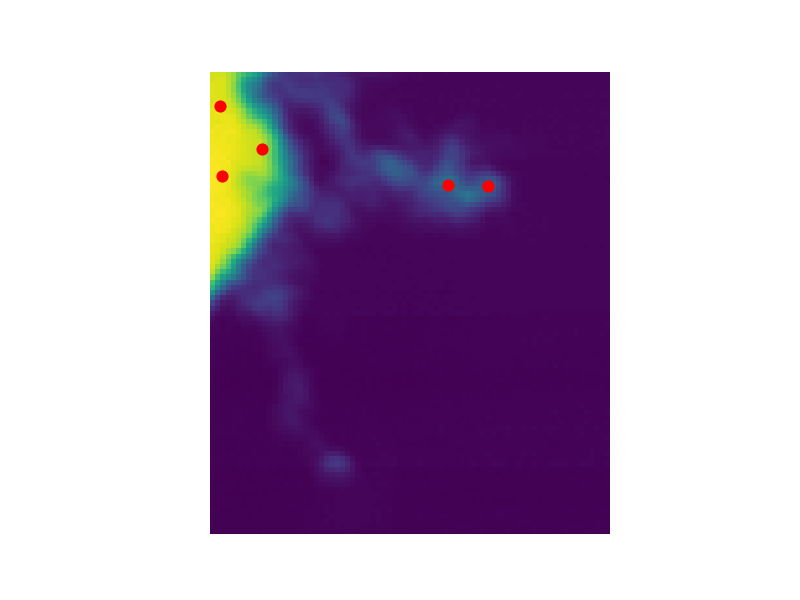

In [5]:
%matplotlib notebook

# Display the image
plt.imshow(image_2d)
plt.axis('off')

# Create empty lists to store the selected points
selected_points = []

# Function to handle mouse click events
def onclick(event):
    if event.button == 1:  
        selected_points.append((event.xdata, event.ydata))
        plt.plot(event.xdata, event.ydata, 'ro')
        plt.draw()

# Connect the click event to the figure
fig = plt.gcf()
fig.canvas.mpl_connect('button_press_event', onclick)

# Show the plot and wait for user interaction
plt.show()

### ROI definition

As the image is composed of few pixels and python accepts coordinates of the clicks which are floats, a method to round the position of the clicks and transform them into real coordinates is needed. Also, based on how images are "seen" by python, we need to switch the coordinates of the points. Finally, the spectra are extracted and plotted, the figure is also saved.

[(6, 1), (20, 2), (14, 10), (21, 45), (22, 53)]


<IPython.core.display.Javascript object>


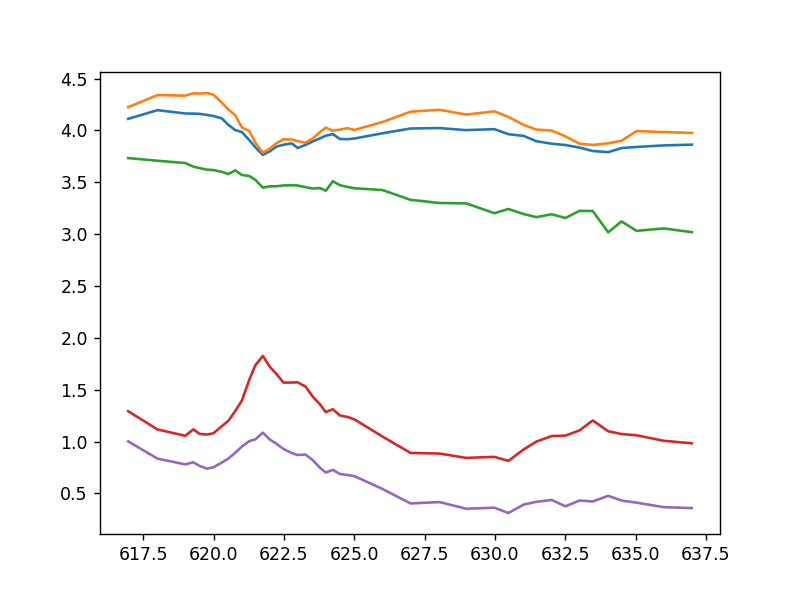

In [6]:
# Round to the nearest pixel and create the roi

roi = [(round(selected_points[i][1]), round(selected_points[i][0])) for i in range(0, len(selected_points))]
print(roi)

# Extract the spectra of the ROI

exroi = roi_spec(roi)

# Plot and save the file

plt.figure()

for i in range(len(exroi)):
    plt.plot(energies, exroi[i])
    
plt.savefig('output.png')

plt.show()

### Dataset extraction as a csv file

In this section all the spectra are inserted in a DataFrame as columns, while the headers corresponds to the coordinates at which that spectrum was extracted. The first column is going to be the energy column.

In [13]:
header_bad = list(str(roi[i]) for i in range(0,len(roi)))
header_bad.insert(0, 'Energy')

header = [s.replace('(', '').replace(')', '').replace(', ', ':') for s in header_bad]

output_array = np.column_stack(exroi)
output_array_energy = np.insert(output_array, 0, energies, axis=1)
output = pd.DataFrame(output_array_energy)
output.columns = header
output.to_csv('data.csv', index=False)